In [37]:
import boto3
import pickle
import matplotlib as plt
import pandas as pd
import numpy as np
import seaborn as sns

import statsmodels.formula.api as smf
from sklearn.preprocessing import StandardScaler
import matplotlib.dates as mdates
import statsmodels.api as sm
from patsy import dmatrix



%matplotlib inline

In [4]:
bucket_name = 'tfl-cycle-data'
s3_file_path = 'Docking_station_data/Waterloo-Jan2016-Apr2024.pkl'
notebook_file_path = 'temp/Waterloo-Jan2016-Apr2024.pkl'
s3 = boto3.client('s3')

s3.download_file(bucket_name, s3_file_path, notebook_file_path)

In [5]:
with open(notebook_file_path, 'rb') as f:
    waterloo_df = pickle.load(f)

In [6]:
waterloo_df.head()

,Rental ID,Start Date,Start Station Name,End Date,End Station Name
0,50755276,2016-10-01 08:41:00,"William IV Street, Strand",2016-10-01 08:47:00,"Waterloo Station 3, Waterloo"
1,50755420,2016-10-01 09:05:00,"Bermondsey Street, Bermondsey",2016-10-01 09:15:00,"Waterloo Station 3, Waterloo"
2,50755598,2016-10-01 09:28:00,"Lollard Street, Vauxhall",2016-10-01 09:36:00,"Waterloo Station 3, Waterloo"
3,50755603,2016-10-01 09:28:00,"Lollard Street, Vauxhall",2016-10-01 09:36:00,"Waterloo Station 3, Waterloo"
4,50756101,2016-10-01 10:12:00,"Waterloo Station 3, Waterloo",2016-10-01 10:27:00,"Braham Street, Aldgate"


In [7]:
waterloo_df_out = waterloo_df[waterloo_df['Start Station Name'] == 'Waterloo Station 3, Waterloo']
waterloo_df_in = waterloo_df[waterloo_df['End Station Name'] == 'Waterloo Station 3, Waterloo']

waterloo_df_out.head()

,Rental ID,Start Date,Start Station Name,End Date,End Station Name
4,50756101,2016-10-01 10:12:00,"Waterloo Station 3, Waterloo",2016-10-01 10:27:00,"Braham Street, Aldgate"
7,50758609,2016-10-01 12:24:00,"Waterloo Station 3, Waterloo",2016-10-01 12:39:00,"Kennington Oval, Oval"
8,50759951,2016-10-01 13:10:00,"Waterloo Station 3, Waterloo",2016-10-01 13:56:00,"Eversholt Street , Camden Town"
9,50759954,2016-10-01 13:10:00,"Waterloo Station 3, Waterloo",2016-10-01 13:56:00,"Eversholt Street , Camden Town"
10,50759977,2016-10-01 13:11:00,"Waterloo Station 3, Waterloo",2016-10-01 13:56:00,"Eversholt Street , Camden Town"


In [8]:
waterloo_df_out = waterloo_df[waterloo_df['Start Station Name'] == 'Waterloo Station 3, Waterloo']

waterloo_df_out.set_index('Start Date', inplace=True)
rentals_5min = waterloo_df_out.resample('5min').size().reset_index(name='Rentals')

rentals_5min.head(10)

,Start Date,Rentals
0,2015-01-02 01:45:00,1
1,2015-01-02 01:50:00,0
2,2015-01-02 01:55:00,0
3,2015-01-02 02:00:00,0
4,2015-01-02 02:05:00,0
5,2015-01-02 02:10:00,0
6,2015-01-02 02:15:00,0
7,2015-01-02 02:20:00,0
8,2015-01-02 02:25:00,0
9,2015-01-02 02:30:00,0


<Axes: xlabel='Start Date', ylabel='Rentals'>

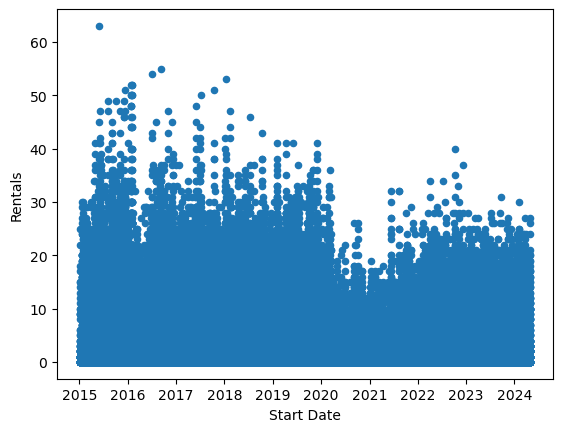

In [9]:
rentals_5min.plot.scatter(x='Start Date', y='Rentals')

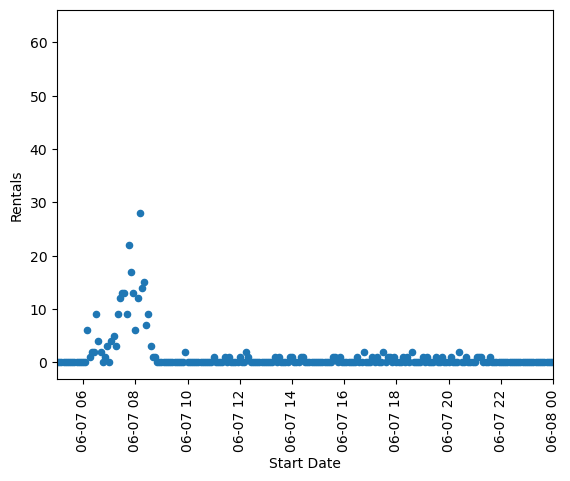

In [10]:
ax = rentals_5min.plot.scatter(x='Start Date', y='Rentals')
ax.set_xlim(pd.to_datetime('2022-06-07 05:00:00'), pd.to_datetime('2022-06-8 00:00:00'))
ax.tick_params(axis='x', rotation=90)
# plt.show()

In [11]:
rentals_5min['Time_Interval'] = (rentals_5min['Start Date'] - rentals_5min['Start Date'].min()).dt.total_seconds() / 60
scaler = StandardScaler()
rentals_5min['Time_Interval_Std'] = scaler.fit_transform(rentals_5min[['Time_Interval']])

rentals_5min.head()

,Start Date,Rentals,Time_Interval,Time_Interval_Std
0,2015-01-02 01:45:00,1,0.0,-1.732049
1,2015-01-02 01:50:00,0,5.0,-1.732046
2,2015-01-02 01:55:00,0,10.0,-1.732042
3,2015-01-02 02:00:00,0,15.0,-1.732038
4,2015-01-02 02:05:00,0,20.0,-1.732035


### Below are failed experiments to model using poisson model - I think multivariate?

In [12]:
# # Fitting the Poisson regression model
# poisson_model = smf.poisson('Rentals ~ Time_Interval_Std', data=rentals_5min).fit()

In [13]:
# # Displaying the summary of the model
# poisson_model_std_summary = poisson_model.summary()
# print(poisson_model_std_summary)

In [14]:
# # Create future time intervals for the next 24 hours
# future_intervals = pd.date_range(start=rentals_5min['Start Date'].max(), periods=24*12, freq='5min')
# future_intervals_df = pd.DataFrame({'Start Date': future_intervals})

# # Standardize the future intervals
# future_intervals_df['Time_Interval'] = (future_intervals_df['Start Date'] - rentals_5min['Start Date'].min()).dt.total_seconds() / 60
# future_intervals_df['Time_Interval_Std'] = scaler.transform(future_intervals_df[['Time_Interval']])

# # Predict the rental rates for future intervals
# future_intervals_df['Predicted_Rentals'] = poisson_model.predict(future_intervals_df[['Time_Interval_Std']])
# future_intervals_df.head()

In [15]:
# future_intervals_df.plot.scatter(x='Start Date', y='Predicted_Rentals')

In [16]:
# # Add hour and day of the week to the dataset
# rentals_5min['Hour'] = rentals_5min['Start Date'].dt.hour
# rentals_5min['Day_of_Week'] = rentals_5min['Start Date'].dt.dayofweek

# # Fitting the Poisson regression model with new features
# poisson_model_aug = smf.poisson('Rentals ~ Time_Interval_Std + C(Hour) + C(Day_of_Week)', data=rentals_5min).fit()

# # Displaying the summary of the model
# poisson_model_aug_summary = poisson_model_aug.summary()
# print(poisson_model_aug_summary)

In [17]:
# # Create future time intervals for the next 24 hours
# future_intervals = pd.date_range(start=rentals_5min['Start Date'].max(), periods=24*12, freq='5min')
# future_intervals_df = pd.DataFrame({'Start Date': future_intervals})
# future_intervals_df['Hour'] = future_intervals_df['Start Date'].dt.hour
# future_intervals_df['Day_of_Week'] = future_intervals_df['Start Date'].dt.dayofweek

# # Standardize the future intervals
# future_intervals_df['Time_Interval'] = (future_intervals_df['Start Date'] - rentals_5min['Start Date'].min()).dt.total_seconds() / 60
# future_intervals_df['Time_Interval_Std'] = scaler.transform(future_intervals_df[['Time_Interval']])

# # Predict the rental rates for future intervals
# future_intervals_df['Predicted_Rentals'] = poisson_model_aug.predict(future_intervals_df[['Time_Interval_Std', 'Hour', 'Day_of_Week']])
# future_intervals_df.head()

In [18]:
# future_intervals_df.plot.scatter(x='Start Date', y='Predicted_Rentals')

In [19]:
# import statsmodels.api as sm

# # Define the minimum and maximum values for the x-axis
# xmin = pd.to_datetime('2024-05-01 06:00')
# xmax = pd.to_datetime('2024-05-01 12:00')

# # Convert these dates to numerical format for setting limits
# xmin_numeric = mdates.date2num(xmin)
# xmax_numeric = mdates.date2num(xmax)

# # Convert Start Date to numerical format for plotting
# future_intervals_df['Start Date Numeric'] = mdates.date2num(future_intervals_df['Start Date'])

# # Create the plot
# plt.figure(figsize=(12, 6))
# sns.scatterplot(x='Start Date', y='Predicted_Rentals', data=future_intervals_df, label='Predicted Rentals')

# # Adding a smooth line using LOWESS (Locally Weighted Scatterplot Smoothing)
# lowess = sm.nonparametric.lowess
# smoothed = lowess(future_intervals_df['Predicted_Rentals'], future_intervals_df['Start Date Numeric'], frac=0.1)

# plt.plot(mdates.num2date(smoothed[:, 0]), smoothed[:, 1], color='red', label='Trend Line')

# # Add title and labels
# plt.title('Predicted Rentals Over Time')
# plt.xlabel('Start Date')
# plt.ylabel('Predicted Rentals')
# plt.legend()

# # Rotate x-axis labels for better readability
# plt.xticks(rotation=45)

# # Set x-axis limits
# plt.gca().set_xlim(xmin, xmax)

# # Format x-axis to show dates
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
# plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))

# # Show the plot
# plt.show()

I THINK IT MAY BE BREAKING BECAUSE THERE ARE TOO MANY PARAMETERS IE ONE FOR EVERY 5 MINUTE PERIOD IN 24 HOURS - 720. ANOTHER MODELING METHOD REQUIRED!

In [20]:
# Add hour and day of the week to the dataset
rentals_5min['Day_of_Week'] = rentals_5min['Start Date'].dt.dayofweek
rentals_5min['Hour'] = rentals_5min['Start Date'].dt.hour
rentals_5min['Minute'] = rentals_5min['Start Date'].dt.minute
rentals_5min['MinuteHour'] = 60*rentals_5min['Hour'].astype(int) + rentals_5min['Minute'].astype(int)

# Ensure Hour and Day_of_Week are categories
rentals_5min['Hour'] = rentals_5min['Hour'].astype('category')
rentals_5min['Day_of_Week'] = rentals_5min['Day_of_Week'].astype('category')
rentals_5min['Minute'] = rentals_5min['Minute'].astype('category')
rentals_5min['MinuteHour'] = rentals_5min['MinuteHour'].astype('category')





In [21]:
# # Create spline terms for the training data
spline_features = dmatrix("cr(Time_Interval_Std, df=5) + C(Day_of_Week) + C(MinuteHour)", data=rentals_5min, return_type='dataframe')
response = rentals_5min['Rentals']

In [22]:
import psutil
import time

# Function to print current resource usage
def print_system_usage():
    print("CPU Usage: ", psutil.cpu_percent(), "%")
    print("Memory Usage: ", psutil.virtual_memory().percent, "%")
    print("Disk Usage: ", psutil.disk_usage('/').percent, "%")

# Monitor resource usage
print_system_usage()

CPU Usage:  6.4 %
Memory Usage:  26.3 %
Disk Usage:  64.7 %


In [24]:
# Use a subset of the data for initial testing
temporal_subset = rentals_5min.iloc[:len(rentals_5min) // 10]
spline_features_subset = dmatrix("cr(Time_Interval_Std, df=5) + C(Day_of_Week) + C(MinuteHour)", data=temporal_subset, return_type='dataframe')
response_subset = temporal_subset['Rentals']

In [33]:
# Checking for NaN, inf or invald values
# Check for NaN values
print(rentals_5min.isna().sum())

# Check for infinite values
numerical_cols = rentals_5min.select_dtypes(include=[np.number]).columns

# Check for infinite values in numerical columns
print(rentals_5min[numerical_cols].applymap(np.isinf).sum())

Start Date           0
Rentals              0
Time_Interval        0
Time_Interval_Std    0
Day_of_Week          0
Hour                 0
Minute               0
MinuteHour           0
dtype: int64


/tmp/ipykernel_26930/3235277328.py:9: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  print(rentals_5min[numerical_cols].applymap(np.isinf).sum())


Rentals              0
Time_Interval        0
Time_Interval_Std    0
dtype: int64


<Axes: >

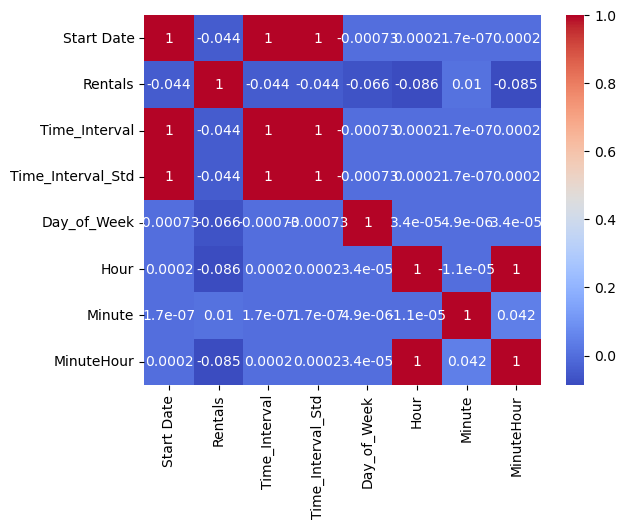

In [36]:
# Calculate the correlation matrix
correlation_matrix = rentals_5min.corr()

# Plot the heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')

In [28]:
temporal_subset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98118 entries, 0 to 98117
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   Start Date         98118 non-null  datetime64[ns]
 1   Rentals            98118 non-null  int64         
 2   Time_Interval      98118 non-null  float64       
 3   Time_Interval_Std  98118 non-null  float64       
 4   Day_of_Week        98118 non-null  category      
 5   Hour               98118 non-null  category      
 6   Minute             98118 non-null  category      
 7   MinuteHour         98118 non-null  category      
dtypes: category(4), datetime64[ns](1), float64(2), int64(1)
memory usage: 3.5 MB


In [29]:
# Fit the Poisson model
poisson_model_spline = sm.GLM(response_subset, spline_features_subset, family=sm.families.Poisson()).fit()
print(poisson_model_spline.summary())

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/statsmodels/genmod/families/links.py:527: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:445: RuntimeWarning: invalid value encountered in true_divide
  endog_mu = self._clean(endog / mu)
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: invalid value encountered in multiply
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/statsmodels/genmod/families/family.py:143: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))
/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/statsmodels/genmod/generalized_linear_model.py:1328: RuntimeWarning: invalid value encountered in multiply


ValueError: NaN, inf or invalid value detected in weights, estimation infeasible.

In [29]:
# # Fit the Poisson model
poisson_model_spline = sm.GLM(temporal_subset, spline_features_subset, family=sm.families.Poisson()).fit()

ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

In [ ]:


# # Create spline terms for future intervals
future_spline_features = dmatrix("cr(Time_Interval_Std, df=5) + C(Hour) + C(Day_of_Week) + C(Minute)", data=future_intervals_df, return_type='dataframe')

# # Predict using the spline Poisson model
future_intervals_df['Predicted_Rentals'] = poisson_model_spline.predict(future_spline_features)

# Fitting the Poisson regression model with new features
poisson_model_aug2 = smf.poisson('Rentals ~ Time_Interval_Std + C(Day_of_Week) + C(MinuteHour)', data=rentals_5min).fit()

# Displaying the summary of the model
poisson_model_aug_summary2 = poisson_model_aug2.summary()
print(poisson_model_aug_summary2)

In [20]:
# Create future time intervals for the next 24 hours
future_intervals = pd.date_range(start=rentals_5min['Start Date'].max(), periods=24*12, freq='5min')
future_intervals_df = pd.DataFrame({'Start Date': future_intervals})
future_intervals_df['Hour'] = future_intervals_df['Start Date'].dt.hour
future_intervals_df['Day_of_Week'] = future_intervals_df['Start Date'].dt.dayofweek
future_intervals_df['Minute'] = future_intervals_df['Start Date'].dt.minute
future_intervals_df['MinuteHour'] = 60*future_intervals_df['Hour'].astype(int) + future_intervals_df['Minute'].astype(int)

# Standardize the future intervals
future_intervals_df['Time_Interval'] = (future_intervals_df['Start Date'] - rentals_5min['Start Date'].min()).dt.total_seconds() / 60
future_intervals_df['Time_Interval_Std'] = scaler.transform(future_intervals_df[['Time_Interval']])

# Predict the rental rates for future intervals
future_intervals_df['Predicted_Rentals'] = poisson_model_aug2.predict(future_intervals_df[['Time_Interval_Std', 'Day_of_Week', 'MinuteHour']])
future_intervals_df.head()

NameError: name 'poisson_model_aug2' is not defined

In [ ]:
# import statsmodels.api as sm

# # Define the minimum and maximum values for the x-axis
# xmin = pd.to_datetime('2024-05-01 06:00')
# xmax = pd.to_datetime('2024-05-01 12:00')

# # Convert these dates to numerical format for setting limits
# xmin_numeric = mdates.date2num(xmin)
# xmax_numeric = mdates.date2num(xmax)

# # Convert Start Date to numerical format for plotting
# future_intervals_df['Start Date Numeric'] = mdates.date2num(future_intervals_df['Start Date'])

# # Create the plot
# plt.figure(figsize=(12, 6))
# sns.scatterplot(x='Start Date', y='Predicted_Rentals', data=future_intervals_df, label='Predicted Rentals')

# # Adding a smooth line using LOWESS (Locally Weighted Scatterplot Smoothing)
# lowess = sm.nonparametric.lowess
# smoothed = lowess(future_intervals_df['Predicted_Rentals'], future_intervals_df['Start Date Numeric'], frac=0.1)

# plt.plot(mdates.num2date(smoothed[:, 0]), smoothed[:, 1], color='red', label='Trend Line')

# # Add title and labels
# plt.title('Predicted Rentals Over Time')
# plt.xlabel('Start Date')
# plt.ylabel('Predicted Rentals')
# plt.legend()

# # Rotate x-axis labels for better readability
# plt.xticks(rotation=45)

# # Set x-axis limits
# plt.gca().set_xlim(xmin, xmax)

# # Format x-axis to show dates
# plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d %H:%M'))
# plt.gca().xaxis.set_major_locator(mdates.HourLocator(interval=6))

# # Show the plot
# plt.show()

In [ ]:
rentals_5min['MinuteHour'] = 60*rentals_5min['Hour'].astype(int) + rentals_5min['Minute'].astype(int)
rentals_5min.head()